In [23]:
# ========================================
# 1. Importações e Setup Geral
# ========================================

In [24]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.arima.model import ARIMA

# Ignorar avisos para uma saída mais limpa
warnings.filterwarnings("ignore")

In [25]:
# =======================================
# 2. Funções de Carregamento de Dados
# ========================================

In [26]:
def salvar_dataset_local(serie, dataset_name):
    """
    Apenas salva uma série temporal em um arquivo CSV local.
    """
    dir_path = "./datasets"
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f"{dataset_name.lower()}.csv")
    df = pd.DataFrame({"date": serie.index, "value": serie.values})
    df.to_csv(file_path, index=False)
    print(f"-> Cópia do dataset '{dataset_name}' salva em: {file_path}")


def carregar_serie(nome):
    """
    Sempre busca a série do statsmodels e salva uma cópia local.
    """
    print(f"Buscando dados de '{nome}' via statsmodels...")
    nome_base = nome.lower()

    if nome_base == "airpassengers":
        df = get_rdataset("AirPassengers", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1949-01-01", periods=len(df), freq="MS"),
                          name="AirPassengers")
    elif nome_base == "lynx":
        df = get_rdataset("lynx", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1821", periods=len(df), freq="A"), name="Lynx")
    elif nome_base == "co2":
        df = get_rdataset("CO2", package="datasets").data
        df = df.ffill()
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1958-03-29", periods=len(df), freq="MS"),
                          name="CO2")
    elif nome_base == "sunspots":
        df = get_rdataset("sunspots", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1749-01-01", periods=len(df), freq="MS"),
                          name="Sunspots")
    elif nome_base == "austres":
        df = get_rdataset("austres", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1971-03-01", periods=len(df), freq="QS-MAR"),
                          name="AustralianResidents")
    elif nome_base == "nottem":
        df = get_rdataset("nottem", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1920-01-01", periods=len(df), freq="MS"),
                          name="Nottingham")
    else:
        raise ValueError(f"Série '{nome}' não reconhecida.")

    salvar_dataset_local(serie, nome)
    return serie

In [27]:
# =========================================================
# 3. Funções Modulares de Modelagem, Previsão e Plotagem
# =========================================================

In [28]:
# Aqui criamos nossas funções reutilizáveis para cada etapa.

def treinar_modelo_arima(serie_treino, ordem):
    """
    Treina um modelo ARIMA com a série e a ordem especificadas.

    Args:
        serie_treino (pd.Series): Série temporal para treinamento.
        ordem (tuple): A ordem (p, d, q) do modelo ARIMA.

    Returns:
        ARIMAResultsWrapper: O modelo treinado.
    """
    print(f"Treinando modelo ARIMA com ordem {ordem}...")

    # # Garantimos que a frequência está definida para evitar avisos
    # serie_com_freq = serie_treino.asfreq(serie_treino.index.freqstr)

    model = ARIMA(serie_treino, order=ordem)
    model_fit = model.fit()
    print("Treinamento concluído.")
    return model_fit

In [29]:
def prever_proximos_passos(model_fit, n_passos):
    """
    Gera a previsão para os próximos N passos e o intervalo de confiança.

    Args:
        model_fit (ARIMAResultsWrapper): O modelo treinado.
        n_passos (int): O número de passos à frente para prever.

    Returns:
        tuple: (previsao_pontual, intervalo_confianca)
    """
    print(f"Gerando previsão para os próximos {n_passos} passos...")
    previsao_pontual = model_fit.forecast(steps=n_passos)

    # Usamos .get_forecast() para obter o objeto completo de previsão
    forecast_object = model_fit.get_forecast(steps=n_passos)
    intervalo_confianca = forecast_object.conf_int(alpha=0.05)  # 95% de confiança

    return previsao_pontual, intervalo_confianca

In [30]:
def plotar_previsao_futura(serie_historica, previsao, intervalo_confianca, nome_serie, n_passos):
    """
    Plota os dados históricos junto com a previsão futura e seu intervalo de confiança.
    """
    print("Plotando o gráfico com os resultados...")
    fig, ax = plt.subplots(figsize=(15, 6))

    # Plotar os dados históricos (dando um zoom nos últimos anos para melhor visualização)
    anos_historico = 5
    inicio_plot = serie_historica.index[-1] - pd.DateOffset(years=anos_historico)
    serie_historica.loc[inicio_plot:].plot(ax=ax, label='Dados Históricos', color='blue')

    # Plotar a previsão pontual
    previsao.plot(ax=ax, label='Previsão Futura', color='red', linestyle='--')

    # Plotar o intervalo de confiança
    ax.fill_between(intervalo_confianca.index,
                    intervalo_confianca.iloc[:, 0],  # Limite inferior
                    intervalo_confianca.iloc[:, 1],  # Limite superior
                    color='pink', alpha=0.6, label='Intervalo de Confiança (95%)')

    # Detalhes do gráfico
    ax.set_title(f'Previsão dos Próximos {n_passos} Passos para a Série {nome_serie}', fontsize=16)
    ax.set_xlabel('Ano')
    ax.set_ylabel('Valor')
    ax.legend(loc='upper left')
    plt.grid(True)
    plt.show()

Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./datasets\airpassengers.csv
Treinando modelo ARIMA com ordem (12, 1, 1)...
Treinamento concluído.
Gerando previsão para os próximos 12 passos...
Plotando o gráfico com os resultados...


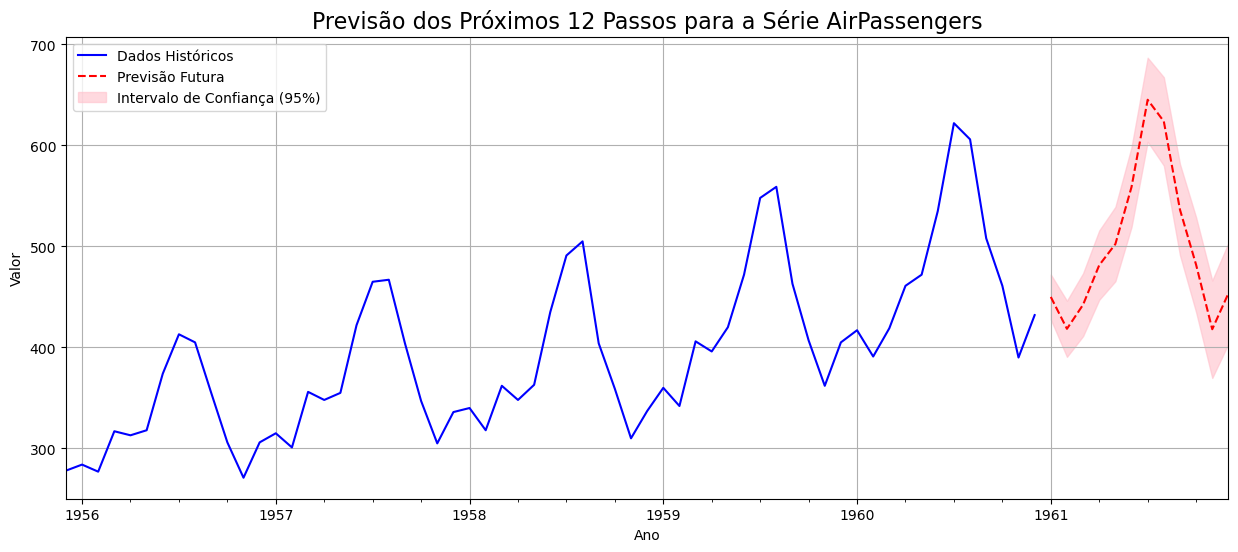


--- Previsões Detalhadas ---
1961-01-01    449.983877
1961-02-01    418.415043
1961-03-01    442.306588
1961-04-01    481.468349
1961-05-01    502.322079
1961-06-01    558.815865
1961-07-01    645.202637
1961-08-01    623.768583
1961-09-01    536.416821
1961-10-01    481.793426
1961-11-01    418.007224
1961-12-01    453.490471
Freq: MS, Name: predicted_mean, dtype: float64


In [31]:
# =========================================================
# 4. Execução da Sessão de Previsão
# =========================================================
# Nesta seção, nós orquestramos a chamada das funções.

# --- 4.1. Configurações da Sessão ---
NOME_DA_SERIE = "AirPassengers"
ORDEM_ARIMA = (12, 1, 1)
forecast_horizont = 12  # Horizonte de previsão (N passos)

# --- 4.2. Preparação dos Dados ---
# Para prever o futuro, treinamos o modelo com todos os dados disponíveis.
serie_completa = carregar_serie(NOME_DA_SERIE)

# --- 4.3. Treinamento do Modelo ---
modelo_treinado = treinar_modelo_arima(serie_completa, ORDEM_ARIMA)

# --- 4.4. Geração da Previsão ---
previsao_futura, ic_futuro = prever_proximos_passos(modelo_treinado, forecast_horizont)

# --- 4.5. Visualização do Resultado ---
plotar_previsao_futura(serie_completa, previsao_futura, ic_futuro, NOME_DA_SERIE, forecast_horizont)

print("\n--- Previsões Detalhadas ---")
print(previsao_futura)

# =========================================================
# 5. Conclusão e Próximos Passos
# =========================================================
#
# A estrutura modular que criamos facilita muito a experimentação.
# Agora você pode facilmente:
# 1. Alterar o NOME_DA_SERIE ou a ORDEM_ARIMA nas configurações e rodar tudo de novo.
# 2. Criar uma nova função, como `treinar_modelo_nbeats(...)`, e compará-la com o ARIMA.
# 3. Adicionar uma função `avaliar_modelo(...)` para calcular métricas de erro.
#
# Lembre-se que para a série 'AirPassengers', o modelo SARIMA (Sazonal)
# produziria resultados ainda melhores, pois capturaria os picos e vales anuais.